In [1]:
import torch
from torch import nn, optim
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
gpu = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu = True
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available


In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)
batch_size = 512
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True, num_workers=4)

torch.Size([512, 1, 28, 28])
torch.Size([512])
tensor(0)


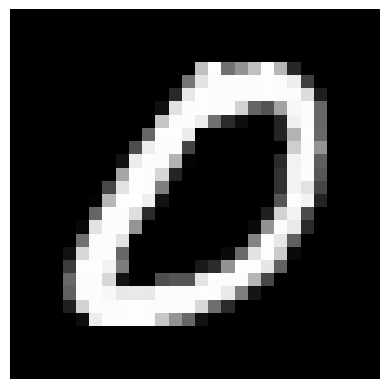

(28, 28)

In [4]:
from matplotlib import pyplot as plt
for batch in train_dataloader:
    img, label = batch
    print(img.shape)
    print(label.shape)
    print(label[0])
    plt.imshow(img[0, 0, :, :].numpy(), cmap='gray')
    plt.axis('off')
    plt.show()
    img_w = img.shape[2]
    img_h = img.shape[3]
    break;
img_w, img_h

In [5]:
class GANGenerator(nn.Module):
    def __init__(self, latent_size, hidden_size , output_size, **kwargs):
        super(GANGenerator, self).__init__(**kwargs)
        self.l1 = nn.Linear(latent_size, hidden_size)
        self.a1 = nn.Sigmoid()
        self.l2 = nn.Linear(hidden_size, output_size)
        self.a2 = nn.Sigmoid()

    def forward(self, X):
        X = self.l1(X)
        X = self.a1(X)
        X = self.l2(X)
        X = self.a2(X)
        return X

In [6]:
class GANDiscriminator(nn.Module):
    def __init__(self, output_size, hidden_size, **kwargs):
        super(GANDiscriminator, self).__init__(**kwargs)
        self.l1 = nn.Linear(output_size, hidden_size)
        self.a1 = nn.Sigmoid()
        self.l2 = nn.Linear(hidden_size, 1)
        self.a2 = nn.Sigmoid()

    def forward(self, X):
        X = self.l1(X)
        X = self.a1(X)
        X = self.l2(X)
        X = self.a2(X)
        return X

In [7]:
lr = 5e-4
decay = 0.001
latent_size = 64
net_g = GANGenerator(latent_size, 64, img_w*img_h).to(device)
net_d = GANDiscriminator(img_w*img_h, 128).to(device)
optim_g = optim.AdamW(net_g.parameters(), lr=lr, weight_decay=decay)
optim_d = optim.AdamW(net_d.parameters(), lr=lr, weight_decay=decay)

In [8]:
def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
net_g.apply(xavier_init_weights)
net_d.apply(xavier_init_weights)

GANDiscriminator(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (a1): Sigmoid()
  (l2): Linear(in_features=128, out_features=1, bias=True)
  (a2): Sigmoid()
)

In [9]:
from IPython import display
import numpy as np
max_epoch = 200
def train(data_iter):
    loss_fn = nn.BCELoss()
    label_ones = torch.ones(batch_size, 1).to(device)
    label_zeros = torch.zeros(batch_size, 1).to(device)
    net_d.train()
    net_g.train()

    # 训练历史
    loss_history_g = []
    loss_history_d = []

    for epoch in range(max_epoch):
        # 计算每一轮loss的和
        loss_g_value, loss_d_value = 0, 0
        for X, Y in data_iter:
            optim_g.zero_grad()
            optim_d.zero_grad()
            X = X.to(device)
            X = X.reshape(X.shape[0], X.shape[1], -1)
            latent = torch.rand(batch_size, latent_size).to(device)
            X_fake = net_g(latent)
            fake_loss = torch.abs(X_fake - X).mean()
            g_loss = fake_loss * 0.05 + loss_fn(net_d(X_fake), label_ones)
            g_loss.backward()
            optim_g.step()

            loss_d_fake = loss_fn(net_d(X_fake.detach()), label_zeros)
            loss_d_real = loss_fn(net_d(X).reshape(-1, 1), label_ones[:X.shape[0]])
            loss_d = (loss_d_fake + loss_d_real) / 2
            loss_d.backward()
            optim_d.step()

            # 更改loss和
            loss_g_value += g_loss.item()
            loss_d_value += loss_d.item()

        # 统计每一轮的loss
        loss_history_g.append(loss_g_value)
        loss_history_d.append(loss_d_value)

        # 绘图
        plt.subplot(2, 1, 1)
        plt.plot(np.arange(len(loss_history_g)), loss_history_g)
        plt.subplot(2, 1, 2)
        plt.plot(np.arange(len(loss_history_d)), loss_history_d)
        display.display(plt.gcf())
        display.clear_output(wait=True)

KeyboardInterrupt: 

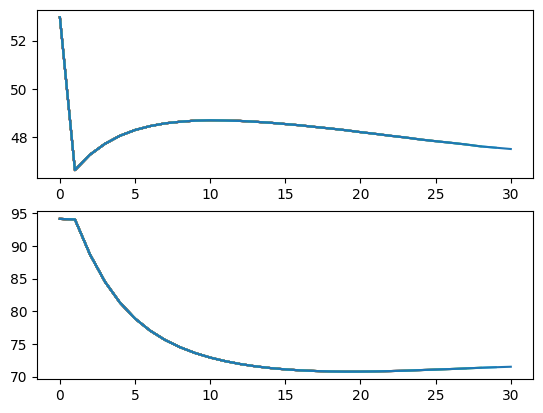

In [10]:
train(train_dataloader)

In [11]:
def predict(net, latent_size, device):
    net.eval()
    sample = torch.randn(1, latent_size).to(device)
    generate = net(sample).cpu().detach().numpy().reshape(28, 28)
    plt.imshow(generate, cmap='gray')
    plt.axis('off')
    plt.show()

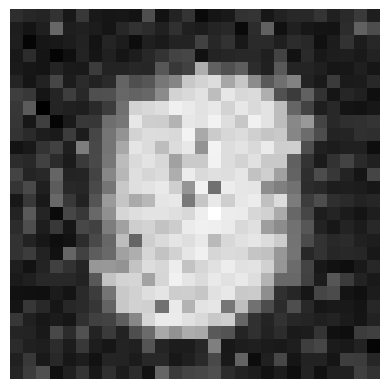

In [70]:
predict(net_g, latent_size, device)